In [91]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from hyperopt import hp, tpe, space_eval, fmin

import warnings
warnings.simplefilter("ignore")

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

from hyperopt import hp, fmin, tpe, space_eval, Trials, STATUS_OK
from functools import partial

In [49]:
path_train = '/home/tefi/Homework/Strahovka/freMPL-R.csv'
df = pd.read_csv(path_train, low_memory=False)
df

,Exposure,LicAge,RecordBeg,RecordEnd,VehAge,Gender,MariStat,SocioCateg,VehUsage,DrivAge,...,ClaimInd,Dataset,DeducType,ClaimNbResp,ClaimNbNonResp,ClaimNbParking,ClaimNbFireTheft,ClaimNbWindscreen,OutUseNb,RiskArea
0,0.583,366,2004-06-01,NaN,2,Female,Other,CSP1,Professional,55,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.200,187,2004-10-19,NaN,0,Male,Alone,CSP55,Private+trip to office,34,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.083,169,2004-07-16,2004-08-16,1,Female,Other,CSP1,Professional,33,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.375,170,2004-08-16,NaN,1,Female,Other,CSP1,Professional,34,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.500,224,2004-01-01,2004-07-01,3,Male,Other,CSP47,Professional,53,...,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343075,0.217,271,2004-10-13,NaN,3,Male,Other,CSP50,Professional,40,...,0,10,NaN,0.0,0.0,0.0,1.0,0.0,1.0,10.0
343076,0.225,583,2004-10-10,NaN,4,Male,Other,CSP60,Private,67,...,0,10,NaN,0.0,0.0,0.0,0.0,0.0,0.0,7.0
343077,0.510,513,2004-01-01,2004-07-05,2,Male,Other,CSP60,Private,65,...,0,10,NaN,2.0,0.0,0.0,0.0,0.0,0.0,7.0
343078,0.833,764,2004-03-01,NaN,5,Male,Other,CSP60,Private,83,...,0,10,NaN,2.0,0.0,0.0,0.0,0.0,0.0,7.0


In [50]:
df = df.loc[df.Dataset.isin([5, 6, 7, 8, 9])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Exposure           115155 non-null  float64
 1   LicAge             115155 non-null  int64  
 2   RecordBeg          115155 non-null  object 
 3   RecordEnd          59455 non-null   object 
 4   Gender             115155 non-null  object 
 5   MariStat           115155 non-null  object 
 6   SocioCateg         115155 non-null  object 
 7   VehUsage           115155 non-null  object 
 8   DrivAge            115155 non-null  int64  
 9   HasKmLimit         115155 non-null  int64  
 10  BonusMalus         115155 non-null  int64  
 11  ClaimAmount        115155 non-null  float64
 12  ClaimInd           115155 non-null  int64  
 13  ClaimNbResp        115155 non-null  float64
 14  ClaimNbNonResp     115155 non-null  float64
 15  ClaimNbParking     115155 non-null  float64
 16  Cl

In [51]:
df.loc[df['RecordEnd'].isnull(), ['RecordEnd']] = '2004-12-31'
df.head()

,Exposure,LicAge,RecordBeg,RecordEnd,Gender,MariStat,SocioCateg,VehUsage,DrivAge,HasKmLimit,BonusMalus,ClaimAmount,ClaimInd,ClaimNbResp,ClaimNbNonResp,ClaimNbParking,ClaimNbFireTheft,ClaimNbWindscreen,OutUseNb,RiskArea
0,0.083,332,2004-01-01,2004-02-01,Male,Other,CSP50,Professional,46,0,50,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,9.0
1,0.916,333,2004-02-01,2004-12-31,Male,Other,CSP50,Professional,46,0,50,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,9.0
2,0.550,173,2004-05-15,2004-12-03,Male,Other,CSP50,Private+trip to office,32,0,68,0.0,0,0.0,2.0,0.0,0.0,0.0,0.0,7.0
3,0.089,364,2004-11-29,2004-12-31,Female,Other,CSP55,Private+trip to office,52,0,50,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
4,0.233,426,2004-02-07,2004-05-01,Male,Other,CSP60,Private,57,0,50,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,7.0


In [52]:
pd.to_datetime(df['RecordBeg'], format='%Y-%m-%d', errors='ignore')
pd.to_datetime(df['RecordEnd'], format='%Y-%m-%d', errors='ignore')

0        2004-02-01
1        2004-12-31
2        2004-12-03
3        2004-12-31
4        2004-05-01
            ...    
115150   2004-12-31
115151   2004-12-31
115152   2004-12-31
115153   2004-07-15
115154   2004-12-31
Name: RecordEnd, Length: 115155, dtype: datetime64[ns]

In [53]:
df['ClaimsCount'] = df.ClaimInd + df.ClaimNbResp + df.ClaimNbNonResp + df.ClaimNbParking + df.ClaimNbFireTheft + df.ClaimNbWindscreen
df.loc[df.ClaimAmount == 0, 'ClaimsCount'] = 0
df.drop(["ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen"], axis=1, inplace=True)

In [54]:
df.loc[df['ClaimsCount'] == 11.0, 'ClaimsCount'] = 10

In [55]:
df['ClaimsCount'].value_counts()

0.0     103609
2.0       3725
1.0       3675
3.0       2402
4.0       1140
5.0        441
6.0        128
7.0         26
8.0          6
9.0          2
10.0         1
Name: ClaimsCount, dtype: int64

In [56]:
# то же самое через groupby
df.groupby(['ClaimsCount'])['Exposure'].count()

ClaimsCount
0.0     103609
1.0       3675
2.0       3725
3.0       2402
4.0       1140
5.0        441
6.0        128
7.0         26
8.0          6
9.0          2
10.0         1
Name: Exposure, dtype: int64

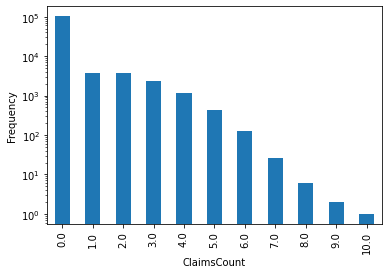

In [57]:
df.groupby(['ClaimsCount'])['Exposure'].count().plot(kind='bar', logy=True)
plt.ylabel('Frequency')
plt.show()

In [58]:
df['weight'] = 0
df.loc[df['ClaimsCount'] == 0, 'weight'] = 0.05
df.loc[df['ClaimsCount'] == 1, 'weight'] = 0.5
df.loc[df['ClaimsCount'] == 2, 'weight'] = 0.5
df.loc[df['ClaimsCount'] == 3, 'weight'] = 0.5
df.loc[df['ClaimsCount'] == 4, 'weight'] = 0.5
df.loc[df['ClaimsCount'] >= 5, 'weight'] = 0.9
df

,Exposure,LicAge,RecordBeg,RecordEnd,Gender,MariStat,SocioCateg,VehUsage,DrivAge,HasKmLimit,BonusMalus,ClaimAmount,ClaimInd,OutUseNb,RiskArea,ClaimsCount,weight
0,0.083,332,2004-01-01,2004-02-01,Male,Other,CSP50,Professional,46,0,50,0.000000,0,0.0,9.0,0.0,0.05
1,0.916,333,2004-02-01,2004-12-31,Male,Other,CSP50,Professional,46,0,50,0.000000,0,0.0,9.0,0.0,0.05
2,0.550,173,2004-05-15,2004-12-03,Male,Other,CSP50,Private+trip to office,32,0,68,0.000000,0,0.0,7.0,0.0,0.05
3,0.089,364,2004-11-29,2004-12-31,Female,Other,CSP55,Private+trip to office,52,0,50,0.000000,0,0.0,8.0,0.0,0.05
4,0.233,426,2004-02-07,2004-05-01,Male,Other,CSP60,Private,57,0,50,0.000000,0,0.0,7.0,0.0,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115150,0.423,238,2004-07-29,2004-12-31,Male,Other,CSP50,Private+trip to office,39,0,50,0.000000,0,4.0,8.0,0.0,0.05
115151,1.000,408,2004-01-01,2004-12-31,Female,Other,CSP55,Private+trip to office,54,0,50,2764.169184,1,0.0,7.0,2.0,0.50
115152,0.805,211,2004-03-11,2004-12-31,Male,Other,CSP55,Private+trip to office,35,0,54,0.000000,0,0.0,7.0,0.0,0.05
115153,0.538,356,2004-01-01,2004-07-15,Male,Other,CSP50,Private,52,0,50,0.000000,0,0.0,7.0,0.0,0.05


In [59]:
df['weight'].value_counts()

0.05    103609
0.50     10942
0.90       604
Name: weight, dtype: int64

In [60]:
x_train, x_valid_1, y_train, y_valid_1 = train_test_split(df.drop(['weight','ClaimsCount', 'RecordBeg', 'RecordEnd', 'Gender', 'MariStat', 'SocioCateg', 'VehUsage'], axis = 'columns'), df['ClaimsCount'] , test_size=0.3, random_state=1)
x_valid, x_test, y_valid, y_test = train_test_split(x_valid_1, y_valid_1, test_size=0.5, random_state=1)


In [61]:
params = {
    "booster": "gbtree",
    "objective": 'multi:softmax',
    'num_class': 11,
    "eval_metric": "mlogloss",
    "learning_rate": 0.1,
    "n_estimators": 100,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27,
    "weight":df['weight']
}

In [62]:
dtrain = xgb.DMatrix(
    data=x_train, label=y_train
)
dvalid = xgb.DMatrix(
    data=x_valid, label=y_valid
)
dtest = xgb.DMatrix(
    data=x_test, label=y_test
)

In [63]:
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=100,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    early_stopping_rounds=50,
    verbose_eval=10,
    maximize=False,
)

[06:30:27] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators, weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-mlogloss:1.91447	valid-mlogloss:1.91465
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 50 rounds.
[10]	train-mlogloss:0.65036	valid-mlogloss:0.64985
[20]	train-mlogloss:0.33497	valid-mlogloss:0.33414
[30]	train-mlogloss:0.22319	valid-mlogloss:0.22220
[40]	train-mlogloss:0.18136	valid-mlogloss:0.18021
[50]	train-mlogloss:0.16529	valid-mlogloss:0.16397
[60]	train-mlogloss:0.15897	valid-mlogloss:0.15756
[70]	train-mlogloss:0.15609	valid-mlogloss:0.15462
[80]	train-mlogloss:0.15450	valid-mlogloss:0.15299
[90]	train-mlogloss:0.15358	valid-mlogloss:0.1520

In [65]:
df

,Exposure,LicAge,RecordBeg,RecordEnd,Gender,MariStat,SocioCateg,VehUsage,DrivAge,HasKmLimit,BonusMalus,ClaimAmount,ClaimInd,OutUseNb,RiskArea,ClaimsCount,weight
0,0.083,332,2004-01-01,2004-02-01,Male,Other,CSP50,Professional,46,0,50,0.000000,0,0.0,9.0,0.0,0.05
1,0.916,333,2004-02-01,2004-12-31,Male,Other,CSP50,Professional,46,0,50,0.000000,0,0.0,9.0,0.0,0.05
2,0.550,173,2004-05-15,2004-12-03,Male,Other,CSP50,Private+trip to office,32,0,68,0.000000,0,0.0,7.0,0.0,0.05
3,0.089,364,2004-11-29,2004-12-31,Female,Other,CSP55,Private+trip to office,52,0,50,0.000000,0,0.0,8.0,0.0,0.05
4,0.233,426,2004-02-07,2004-05-01,Male,Other,CSP60,Private,57,0,50,0.000000,0,0.0,7.0,0.0,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115150,0.423,238,2004-07-29,2004-12-31,Male,Other,CSP50,Private+trip to office,39,0,50,0.000000,0,4.0,8.0,0.0,0.05
115151,1.000,408,2004-01-01,2004-12-31,Female,Other,CSP55,Private+trip to office,54,0,50,2764.169184,1,0.0,7.0,2.0,0.50
115152,0.805,211,2004-03-11,2004-12-31,Male,Other,CSP55,Private+trip to office,35,0,54,0.000000,0,0.0,7.0,0.0,0.05
115153,0.538,356,2004-01-01,2004-07-15,Male,Other,CSP50,Private,52,0,50,0.000000,0,0.0,7.0,0.0,0.05


In [66]:
df['ClaimsCount'].value_counts()

0.0     103609
2.0       3725
1.0       3675
3.0       2402
4.0       1140
5.0        441
6.0        128
7.0         26
8.0          6
9.0          2
10.0         1
Name: ClaimsCount, dtype: int64

In [67]:
df = df.drop(['weight'], axis = 'columns')

In [68]:
df_1 = df[df['ClaimsCount'] == 10]
for i in range (0,1000,1):
    df = pd.concat([df, df_1], axis=0, ignore_index=True)

df_1 = df[df['ClaimsCount'] == 9]
for i in range (0,1000,1):
    df = pd.concat([df, df_1], axis=0, ignore_index=True)

df_1 = df[df['ClaimsCount'] == 8]
for i in range (0,1000,1):
    df = pd.concat([df, df_1], axis=0, ignore_index=True)
    
df_1 = df[df['ClaimsCount'] == 7]
for i in range (0,100,1):
    df = pd.concat([df, df_1], axis=0, ignore_index=True)

df_1 = df[df['ClaimsCount'] == 6]
for i in range (0,100,1):
    df = pd.concat([df, df_1], axis=0, ignore_index=True)

df_1 = df[df['ClaimsCount'] == 5]
for i in range (0,100,1):
    df = pd.concat([df, df_1], axis=0, ignore_index=True)
    
df['ClaimsCount'].value_counts()

0.0     103609
5.0      44541
6.0      12928
8.0       6006
2.0       3725
1.0       3675
7.0       2626
3.0       2402
9.0       2002
4.0       1140
10.0      1001
Name: ClaimsCount, dtype: int64

In [70]:
x_train, x_valid_1, y_train, y_valid_1 = train_test_split(df.drop(['ClaimsCount', 'RecordBeg', 'RecordEnd', 'Gender', 'MariStat', 'SocioCateg', 'VehUsage'], axis = 'columns'), df['ClaimsCount'] , test_size=0.3, random_state=1)
x_valid, x_test, y_valid, y_test = train_test_split(x_valid_1, y_valid_1, test_size=0.5, random_state=1)

dtrain = xgb.DMatrix(
    data=x_train, label=y_train
)
dvalid = xgb.DMatrix(
    data=x_valid, label=y_valid
)
dtest = xgb.DMatrix(
    data=x_test, label=y_test
)

In [71]:
params = {
    "booster": "gbtree",
    "objective": 'multi:softmax',
    'num_class': 11,
    "eval_metric": "mlogloss",
    "learning_rate": 0.1,
    "n_estimators": 100,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27,
}

In [72]:
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=100,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    early_stopping_rounds=50,
    verbose_eval=10,
    maximize=False,
)

[06:33:17] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-mlogloss:2.01457	valid-mlogloss:2.01395
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 50 rounds.
[10]	train-mlogloss:0.92222	valid-mlogloss:0.92138
[20]	train-mlogloss:0.62855	valid-mlogloss:0.62735
[30]	train-mlogloss:0.50864	valid-mlogloss:0.50706
[40]	train-mlogloss:0.45150	valid-mlogloss:0.44982
[50]	train-mlogloss:0.41887	valid-mlogloss:0.41748
[60]	train-mlogloss:0.39571	valid-mlogloss:0.39487
[70]	train-mlogloss:0.37430	valid-mlogloss:0.37369
[80]	train-mlogloss:0.35790	valid-mlogloss:0.35751
[90]	train-mlogloss:0.34583	valid-mlogloss:0.34557
[99]	t

In [74]:
df.ClaimsCount

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
183650    5.0
183651    5.0
183652    5.0
183653    5.0
183654    5.0
Name: ClaimsCount, Length: 183655, dtype: float64

In [82]:
y_pred = model.predict(dtest)


accuracy = accuracy_score(y_test, y_pred) 
print(accuracy)

0.8983629169842825


In [83]:
f1_score = f1_score(y_test, y_pred, average='micro') 
print(f1_score)

TypeError: 'numpy.float64' object is not callable

In [84]:
def xgb_eval_dev_gamma(yhat, dtrain):
    y = dtrain.get_label()
    return 'dev_gamma', 2 * np.sum(-np.log(y/yhat) + (y-yhat)/yhat)

In [95]:
def objective(params, cv_params, data):
    if 'max_depth' in params.keys():
        params['max_depth'] = int(params['max_depth'])
    cv_result = xgb.cv(params=params, dtrain=data, **cv_params)
    name = [i for i in cv_result.columns if all([i.startswith('test-'), i.endswith('-mean')])][-1]
    score = cv_result[name][-1:].values[0]
    return {'loss': score, 'status': STATUS_OK}

In [96]:
space_avgclm = {'objective': 'multi:softmax',
                'max_depth': hp.choice('max_depth', [5, 8, 10, 12, 15]),
                'min_child_weight': hp.uniform('min_child_weight', 0, 50),
                'subsample': hp.uniform('subsample', 0.5, 1),
                'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
                'alpha': hp.uniform('alpha', 0, 1),
                'lambda': hp.uniform('lambda', 0, 1),
                'eta': hp.uniform('eta', 0.01, 1),
                'tree_method': 'hist'
                }   

In [97]:
cv_params = {'num_boost_round': 300,
             'nfold': 5,
             'shuffle': True,
             'stratified': False,
             'feval': xgb_eval_dev_gamma,
             'maximize': False,
             'early_stopping_rounds': 20
              }

In [98]:
trials = Trials()
best = fmin(fn=partial(objective, cv_params=cv_params, data=df),
            space=space_avgclm, trials=trials, algo=tpe.suggest, max_evals=50, timeout=3600)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

job exception: 'DataFrame' object has no attribute 'get_uint_info'



  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]


AttributeError: 'DataFrame' object has no attribute 'get_uint_info'

In [99]:
best_params = space_eval(space_avgclm, best)
best_params

NameError: name 'best' is not defined